<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/parent_document_retriever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neo4j openai tiktoken langchain wikipedia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.4/192.4 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 85.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.1 MB/s eta 0:00:00
  Created wheel for neo4j: filename=neo4j-5.14.0-py3-none-any.whl size=265476 sha256=af2f37125ba1d154f4086a6e675eb2459cbd4431fe4c11d1f6410747c91f714f
  Stored in directory: /root/.cache/pip/wheels/53/e0/d7/603097e3fed62f821523433801c09e04cd7a7610c7565bd5a3
  Created wheel for wikipedia: filename=wiki

#Implementing Parent Document Retriever in Neo4j with LangChain
## Enhancing vector similarity precision by indexing fragmented child node vectors
Retrieval-augmented generation applications seem to be the "Hello World" of AI applications. Nowadays, you can implement a "Chat with your PDF" application in only a couple of minutes due to the help of LLM framework libraries like LangChain and LlamaIndex.
"Chat with your PDF" applications typically rely on vector similarity search to retrieve relevant information, which are then fed to an LLM to generate a final answer that is returned to a user.

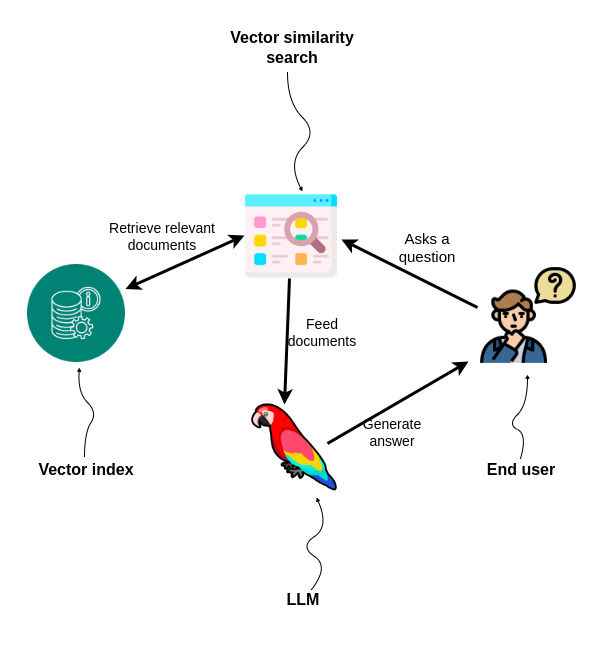

Lately, it is becoming more and more obvious that naive vector similarity search might not be accurate enough for all use cases. For example, we have seen the introduction of [step-back approach to prompting](https://arxiv.org/abs/2310.06117), which emphasizes the importance of taking a step back from the immediate details of a task to focus on a higher-level abstraction.

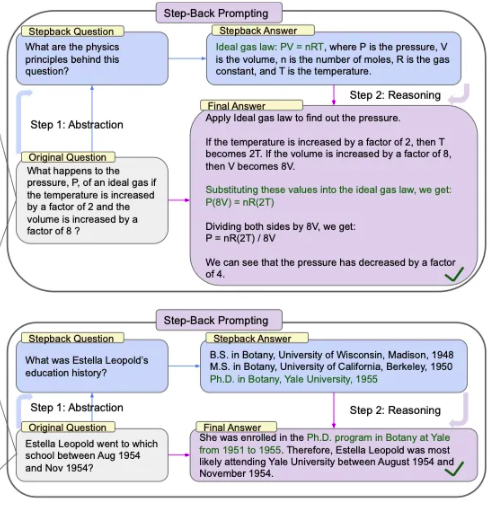

The step-back prompting technique is based on the observation that directly addressing intricate tasks can lead to errors, especially when there are numerous specifics to consider. Instead of plunging straight into the complexities, the model first prompts itself to ask a more generic question that encapsulates the core essence of the original query. By focusing on this broader concept or principle, it can retrieve more relevant and comprehensive facts. Once armed with this foundational knowledge, the model can then proceed to reason and deduce the answer to the specific task at hand.

On the other hand, we can also seen the introduction of so-called parent document retrievers, where the hypothesis is that directly using a document's vector might not be efficient.
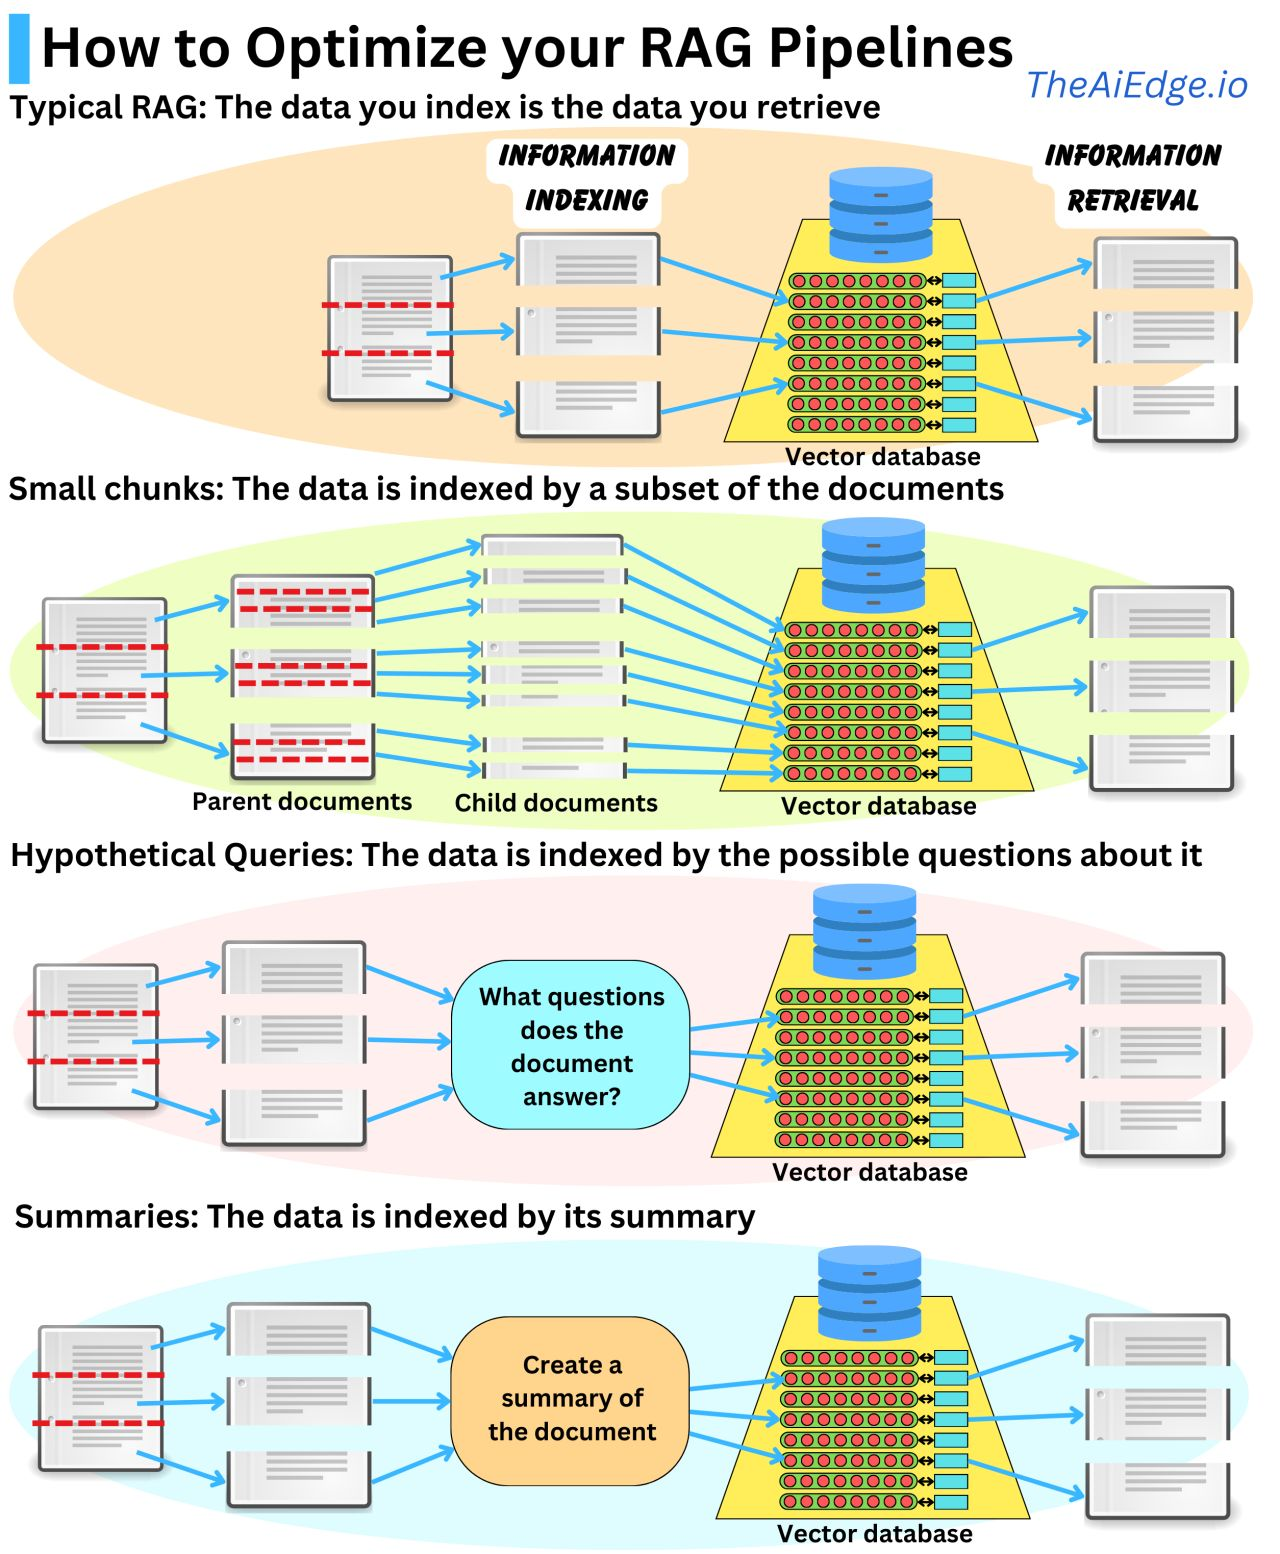

Large documents can be split into smaller chunks, where the smaller chunks are converted to vectors, improving indexing for similarity searches. Although these smaller vectors better represent specific concepts, the original large document is retrieved as it provides better context for answering questions. Similarly, you can use an LLM to generate questions the document answers. The document is then indexed by these question embeddings, providing closer similarity with user questions. In both examples, the full parent document is retrieved to provide complete context for answers, hence the name "Parent Document Retriever".

In this blog post I will demonstrate how to implement Parent Document Retriever strategy with LangChain and Neo4j's vector index.
## Neo4j Environment Setup

You need to set up a Neo4j 5.11 or greater to follow along with the examples in this blog post. The easiest way is to start a free instance on Neo4j Aura, which offers cloud instances of Neo4j database. Alternatively, you can also set up a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance.

In [2]:
from langchain.graphs import Neo4jGraph

url = "neo4j+s://fc4af8ee.databases.neo4j.io"
username = "neo4j"
password = "v7op_Y9UlGs3_hbY3oqxcS6XBPt-23VkKvkuXDGne9M"
graph = Neo4jGraph(url=url, username=username, password=password)

## Constructing a parent-child graph of documents in Neo4j
To keep it simple, we will use the WikipediaLoader available in LangChain to retrieve text from the Walt Disney wiki page. We will begin by constructing a parent-child graph of documents, where the children contain smaller chunks of text.

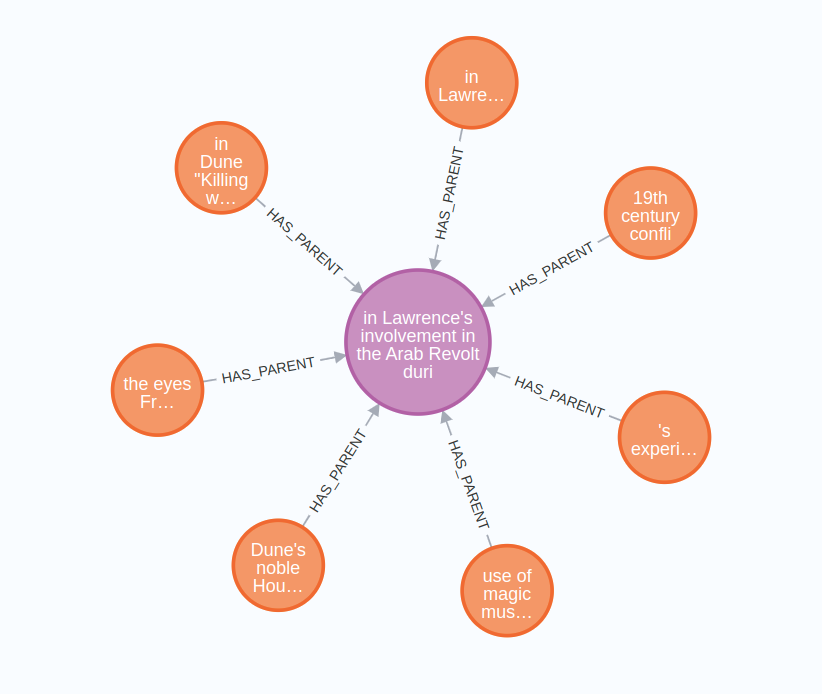

The parent nodes contain longer text with more relevant context, while the children have smaller chunks of text. In this example, only children's text will be embedded and used in vector similarity searches.

The following code starts by loading the Walt Disney Wikipedia page. Next, we define two text splitters: one for parents with a 1000 token limit and the other for children with 100 tokens. Using this text-splitting strategy, each parent will have at most ten children nodes linked. Finally, we split the text using the above-mentioned text splitters and store the output in the Neo4j database.

In [3]:
from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import TokenTextSplitter

# Read the wikipedia article
raw_documents = WikipediaLoader(query="Walt Disney").load()
# Define chunking strategy
parent_splitter = TokenTextSplitter(chunk_size=1000, chunk_overlap=24)
child_splitter = TokenTextSplitter(chunk_size=100, chunk_overlap=24)

parent_documents = parent_splitter.split_documents(raw_documents)
for d in parent_documents:
    child_documents = child_splitter.split_documents([d])
    params = {
        "parent": d.page_content,
        "children": [c.page_content for c in child_documents],
    }
    graph.query(
        """
    CREATE (p:Parent {text: $parent})
    WITH p
    UNWIND $children AS child
    CREATE (c:Child {text: child})
    CREATE (c)-[:HAS_PARENT]->(p)
    """,
        params,
    )

Each parent document forms an island (weakly connected component) in our graph, where the purple nodes are parents, and the orange are children.
## Parent Document retriever
The last thing we need to do is to calculate the embedding values for the Child nodes and index them. This process can be conveniently done with the from_existing_graph method of the Neo4jVector object in LangChain.

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "sk-"

In [ ]:
from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain.embeddings.openai import OpenAIEmbeddings

retrieval_query = """
MATCH (node)-[:HAS_PARENT]->(parent)
RETURN parent.text AS text, score, {} AS metadata
"""

vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password,
    index_name="retrieval",
    node_label="Child",
    text_node_properties=["text"],
    embedding_node_property="embedding",
    retrieval_query=retrieval_query,
)

In [ ]:
response = vector_index.similarity_search("Where was Walt Disney born?")
print(response[0].page_content)

Walter Elias Disney (; December 5, 1901 –  December 15, 1966) was an American animator, film producer, and entrepreneur. A pioneer of the American animation industry, he introduced several developments in the production of cartoons. As a film producer, he holds the record for most Academy Awards earned and nominations by an individual. He was presented with two Golden Globe Special Achievement Awards and an Emmy Award, among other honors. Several of his films are included in the National Film Registry by the Library of Congress and have also been named as some of the greatest films ever by the American Film Institute.
Born in Chicago in 1901, Disney developed an early interest in drawing. He took art classes as a boy and took a job as a commercial illustrator at the age of 18. He moved to California in the early 1920s and set up the Disney Brothers Studio (now The Walt Disney Company) with his brother Roy. With Ub Iwerks, he developed the character Mickey Mouse in 1928, his first highl

The above code iterates over all the nodes labeled Child and calculates embedding representation of text store in the properties defined in text_node_properties. Additionally, we have to define a custom retrieval_query value. The retrieval_query defines the information retrived from the vector similarity search. In this example, the vector similarity search identifies relevant Child nodes, and then traverses the HAS_PARENT relationships to retrieve the text stored in Parent nodes.

Now you can use the constructed vector_index in RAG applications using the built-in LangChain modules.

In [ ]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI

vector_qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(), chain_type="stuff", retriever=vector_index.as_retriever()
)

In [ ]:
response = vector_qa.run("Where was Walt Disney born?")
print(response)

Walt Disney was born in Chicago, Illinois, United States.


## Summary
In today's RAG applications, the ability to retrieve accurate and contextual information from a large text corpus is crucial. The traditional approach to vector similarity search, while powerful, might sometimes overlook the specific context when longer text is embedded. By splitting longer documents into smaller vectors and indexing these for similarity, we can increase the retrieval accuracy while retaining the contextual information of parent documents to generate the answers with LLMs. The example shown in this blog post can easily be modified to adhere to the hypothetical questions or other vector similarity search strategies.